In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import scipy.sparse as sparse

from itertools import chain
from pathlib import *
from math import ceil
from sqlalchemy import create_engine

from helper import *
from tree_weight import *
from time import time
from main import make_graph_from_tree
from multiprocessing import *

from typing import List
%matplotlib inline

In [6]:
image_folder = 'graphs/'
tree = 'benchmark_models/jobshop/trees/jobshop_ft06.sqlite'
info_df = to_df(tree, 'info').set_index('NodeID')
nodes_df = to_df(tree, 'nodes').set_index('NodeID')
# map_dict = {}

# if 'SubtreeSize' not in nodes_df:
#     calculate_subtree_size(nodes_df)
#     to_sqlite(nodes_df, tree)

# valid_df = nodes_df[nodes_df['Status'] != 3]

# def get_split_var(row, mappings=None):
#     node_idx = row.name
#     par_idx = valid_df.loc[node_idx, 'ParentID']
#     if par_idx == - 1:
#         return None
#     cands, _, par_domain, children_domain = find_split_variable(par_idx, valid_df, info_df, mappings)
#     return cands[0] if len(cands) == 1 else None

# def get_parent_column(column: str, df: pd.DataFrame) -> pd.Series:
#     has_root = 1 if 0 == df.index[0] else 0
#     j = df.iloc[has_root:, :].reset_index().set_index('ParentID')[['NodeID', column]]
#     j.loc[:, column] = df.loc[df.iloc[has_root:, :]['ParentID'], column]    
#     return j.reset_index().set_index('NodeID')[column]
    
# valid_df.loc[:, 'SplitVariable'] = valid_df.apply(get_split_var, axis=1, mappings=map_dict)
# valid_df.loc[:, 'SubtreeSizeWeight'] = valid_df['SubtreeSize'] / get_parent_column('SubtreeSize', valid_df)
# valid_df.loc[:, 'SearchSpaceWeight'] = valid_df['SearchSpaceNodeWeight'] / get_parent_column('SearchSpaceNodeWeight', valid_df)

In [3]:
%%time
assign_weight(nodes_df, weight_scheme='searchSpace_scheme', assign_in_dfs_order=False, info_df=info_df)

At node 45, weights retrieved are [1.0]
At node 0, weights retrieved are [0.5, 0.5]
At node 94, weights retrieved are [0.1, 0.9]
At node 47, weights retrieved are [1.0]
At node 95, weights retrieved are [0.5, 0.5]At node 49, weights retrieved are [1.0]

At node 1, weights retrieved are [0.5, 0.5]At node 96, weights retrieved are [0.0625, 0.9375]At node 134, weights retrieved are [0.5, 0.5]
At node 51, weights retrieved are [1.0]


At node 136, weights retrieved are [0.1111111111111111, 0.8888888888888888]
At node 97, weights retrieved are [0.5, 0.5]At node 138, weights retrieved are [0.125, 0.875]At node 2, weights retrieved are [0.5, 0.5]At node 53, weights retrieved are [1.0]



At node 57, weights retrieved are [1.0]
At node 98, weights retrieved are [0.07142857142857142, 0.9285714285714286]At node 3, weights retrieved are [1.0]
At node 58, weights retrieved are [1.0]

At node 59, weights retrieved are [1.0]At node 99, weights retrieved are [0.5, 0.5]
At node 140, weights retrieved 

In [16]:
nodes_df.reset_index()[['ParentID', 'NodeID']]

,ParentID,NodeID
0,-1,0
1,0,1
2,0,2
3,1,3
4,1,4
...,...,...
776,772,776
777,775,777
778,775,778
779,776,779


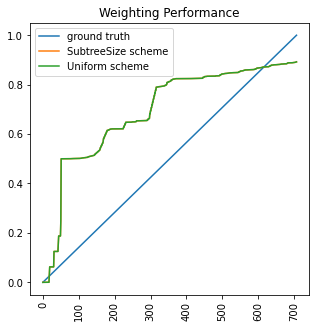

In [13]:
dfs_ordering = nodes_df[nodes_df['DFSOrdering'] != -1]\
                       ['DFSOrdering'].sort_values().index.to_list()
cum_weight = get_cum_weight(nodes_df, 'NodeWeight', dfs_ordering)
uniform_cum = get_cum_weight(nodes_df, 'SearchSpaceNodeWeight', dfs_ordering)
fig, ax = plot_goodness({'SubtreeSize': cum_weight, 'Uniform': uniform_cum})

In [18]:
def assign_weight_at_node(j: int, valid_df: pd.DataFrame,
        weight_colname: str, ws: 'WeightScheme', weight_scheme: str,
        data: list, row: list, col: list) -> None:
    """
    Inner loop of assign_weight. At parent node j, generate weights for j's children

    Args:
        j: index of parent node
        valid_df: dataframe of all valid nodes
        weight_colname: name of weight column
        ws: A weight scheme of object that generates weights for a given node
        weight_scheme: name of weight_scheme
    """
    par_weight = valid_df.loc[j, weight_colname]
    children = valid_df[valid_df['ParentID'].isin([j])]
    
    if children.shape[0] == 0:
        return

    weights = ws.get_weight(j, valid_df)
    # print(f"At node {j}, weights retrieved are {list(weights)}")
    assert len(weights) == children.shape[0]

#     valid_df.loc[children.index, weight_colname] = par_weight * np.array(weights) 
    for k in range(len(children.index)):
        child_id = children.index[k]
        ws.p_matrix_data[child_id] = weights[k]
        ws.p_matrix_data[child_id + len(ws.p_matrix_data) // 3] = j
        ws.p_matrix_data[child_id + 2 * len(ws.p_matrix_data) // 3] = child_id
            
    print(f"At node {j}, data\'s length is {sum(ws.p_matrx_data) // 3}\n")
    
def assign_weight_parallel(nodes_df: pd.DataFrame, weight_scheme: str, 
        weight_colname: str='NodeWeight',
        assign_in_dfs_order: bool=False,
        **kwargs) -> None:
    """
    Assigns weight = 1 to root and propogates that weight down using a weighting scheme.
    Nodes which are backjumped over and pruned are ignored.
    
    Parameter:
        - nodes_df: dataframe of nodes, indexed by nodes_id
        - weight_scheme: name of function defined in WeightScheme class
        - kwargs: keyword arguments required for the weight scheme
    """
    
    invalid_status = [3] # pruned nodes that are jumped over without being considered
    valid_df = pd.DataFrame.copy(nodes_df[~nodes_df['Status'].isin(invalid_status)])
    valid_df.loc[0, weight_colname] = 1 # root node has weight 1
    ws = make_weight_scheme(weight_scheme, assign_in_dfs_order=assign_in_dfs_order, **kwargs)

    # variables to instantiate sparse matrix passed as state into weight scheme
    ws.p_matrix_data = Array('d', (nodes_df.shape[0] - 1) * 3)

    index_lst = valid_df[valid_df['NKids'] > 0].index
    
    try:
#         l = Lock()
        pool = Pool(cpu_count())
        nargs = [(i, valid_df, weight_colname, ws, weight_scheme) for i in index_lst]
        pool.starmap(assign_weight_at_node, nargs)
    finally:
        pool.close()
    
#     print(nodes_df.shape)
#     mat = sparse.csr_matrix(data, (row, col), shape=(nodes_df.shape[0], nodes_df.shape[0]))
    return ws.p_matrix_data
    
#     for i in range(nodes_df.shape[0]):
#         nodes_df.loc[, weight_colname] = valid_df[weight_colname]
#     nodes_df[weight_colname].fillna(0, inplace=True)

In [19]:
data, row, col = assign_weight_parallel(nodes_df, 'searchSpace_scheme', 'NodeWeightTest', assign_in_dfs_order=False, info_df=info_df)

RuntimeError: SynchronizedArray objects should only be shared between processes through inheritance

In [55]:
col

[]

In [50]:
# see if subtree sizes follow the same characteristic

def fit_characteristic(row, nodes_df=None):
    node_id = row.name
    truth = nodes_df[nodes_df['ParentID'] == node_id]['SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s) if len(a_s) > 0 else 0

# for each parent node and the corresponding children
weights = valid_df[valid_df['Status'] == 2].apply(fit_characteristic, nodes_df=valid_df, axis=1)
# weighgs = pd.Series(weights)

# valid_df[valid_df['Status'] == 2].reset_index()['NodeID'].apply(fit_characteristic, nodes_df=valid_df)

In [52]:
weights[weights > 50]

NodeID
90     407.0
92     127.0
218    125.0
220    123.0
222    121.0
224    119.0
228     73.0
300     71.0
302     69.0
304     67.0
374    405.0
376    403.0
378    401.0
380    399.0
382    397.0
384    395.0
386    393.0
388    391.0
402     72.2
433     85.0
436     83.0
dtype: float64

In [53]:
nodes_df[nodes_df['ParentID'] == 374]

,ParentID,Alternative,NKids,Status,Label,DFSOrdering,DomainNodeWeight,NodeWeight,SearchSpaceNodeWeight,SubtreeSize,UniformNodeWeight
NodeID,,,,,,,,,,,
375,374,0,0,1,X_INTRODUCED_17_ = 28,302,1.982886e-34,0.0625,0.011905,1,0.0625
376,374,1,2,2,X_INTRODUCED_17_ != 28,303,4.212590e-20,0.0625,0.226190,405,0.0625


nodes_df['
- total time: 20min
- make_dfs_ordering: 3m30s
- load info_df: 365ms
- load nodes_df: 404ms
- copy nodes_df: 7.96ms
- assign weights to nodes_df: 7min30s
- assign weights to test_df: 12min26s
- get_cum_weights for nodes_df: 156ms
- get_cum_weights for test_df: 125ms


f(par_idx) -> list[nkids weights]

Simple solution:
    f(par_idx) = 
    x = np.array([(weight**i) for i in range(nodes_df.loc[par_idx, 'NKids'])])
    # normalize x so it adds to 1
    x = x / x.sum()

ON.RETURN.TO.HIGHER LEVEL
    seen_idx.append(node_id)
    new_weight = fit_characteristic_weight(seen_idx) # find weight that best fit the known curve
    weight = alpha * weight + (1  - alpha) * new_weight # exponential decay
    
    

INITIALIZE WEIGHT
    weight = 1 # no drop of subtree size
    

def fit_characteristic_weight(seen_idx, nodes_df):
    
    truth = nodes_df.loc[seen_idx, 'SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s)
    
given data subtree_s(0..k):
a1 = subtree_s(1) / subtree_s(0)
a2 = subtree_s(2) / subtree_s(1)
a3 = ...

find w that minimizes 1/2(a1..k - w)^2 -> w = mean(a1, a2, a3, a4)


1, 1/w, 1/w^2, 1/w^3, 1/w^4, ... 1/w^n -> normalized -> 1/w^k * 

sum(1, 1/w, 1/w^2, ... 1/w^n) = S
wS = w + 1 + 1/w + .. + 1/w^(n - 1) = w + S - 1/w^n => S(w - 1) = w - 1/w^n = (w - 1/w^n) / (w - 1)

In [ ]:
nodes_df['No